In [2]:
import tensorflow as tf
from tensorflow import keras
K = keras.backend

# Common imports
import numpy as np
import os
import timeit

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# load data and split into train / validation sets
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, y_train = X_train_full[:45000], y_train_full[:45000]
X_valid, y_valid = X_train_full[45000:], y_train_full[45000:]

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
# initialize a sequential model (using 'stretch pants' approach)
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(1, 21):
    model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

# set optimizer and compile the model
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

# create callbacks
# early stopping 
e_stop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
# model checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint('cifar10_model.h5', save_best_only=True)
# model logging
run_index = 1
run_log_dir = os.path.join(os.curdir, 'cifar_10_logs', 'run_{:03d}'.format(run_index))
# tensorboard callback
tensorboard = keras.callbacks.TensorBoard(run_log_dir)

callbacks = [e_stop, checkpoint]

# fit model
model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
         callbacks=callbacks)

In [7]:
model = keras.models.load_model("cifar10_model.h5")
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
model.evaluate(X_valid, y_valid, verbose=0)

[1.5092333555221558, 0.4681999981403351]

In [12]:
# clear keras session and reset randomizer
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# instantiate new sequential model using Batch Normalization layer
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

# update model checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint('cifar10_bn.h5', save_best_only=True)
callbacks = [e_stop, checkpoint]

model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
         callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 32s 23ms/step - loss: 1.8301 - accuracy: 0.3467 - val_loss: 1.7014 - val_accuracy: 0.3936
Epoch 2/100
1407/1407 [==============================] - 32s 23ms/step - loss: 1.6597 - accuracy: 0.4077 - val_loss: 1.6009 - val_accuracy: 0.4274
Epoch 3/100
1407/1407 [==============================] - 32s 23ms/step - loss: 1.5955 - accuracy: 0.4305 - val_loss: 1.5250 - val_accuracy: 0.4494
Epoch 4/100
1407/1407 [==============================] - 32s 23ms/step - loss: 1.5509 - accuracy: 0.4466 - val_loss: 1.4598 - val_accuracy: 0.4910
Epoch 5/100
1407/1407 [==============================] - 32s 23ms/step - loss: 1.5010 - accuracy: 0.4664 - val_loss: 1.4457 - val_accuracy: 0.4878
Epoch 6/100
1407/1407 [==============================] - 32s 22ms/step - loss: 1.4696 - accuracy: 0.4777 - val_loss: 1.4156 - val_accuracy: 0.5020
Epoch 7/100
1407/1407 [==============================] - 32s 23ms/step - loss: 1.4339 - accuracy: 0.4942 - val_loss: 1

In [14]:
# load saved model, compile and validate
model = keras.models.load_model('cifar10_bn.h5')
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
model.evaluate(X_valid, y_valid, verbose=0)

[1.305877685546875, 0.5418000221252441]

In [16]:
# normalize inputs
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# self-normalizing model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

checkpoint = keras.callbacks.ModelCheckpoint("cifar10_selu.h5", save_best_only=True)
run_index = 1 
run_logdir = os.path.join(os.curdir, "cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [e_stop, checkpoint]

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8861 - accuracy: 0.3240 - val_loss: 1.9271 - val_accuracy: 0.3440
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6707 - accuracy: 0.4055 - val_loss: 1.6433 - val_accuracy: 0.4260
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5721 - accuracy: 0.4440 - val_loss: 1.5915 - val_accuracy: 0.4376
Epoch 4/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4953 - accuracy: 0.4702 - val_loss: 1.5620 - val_accuracy: 0.4472
Epoch 5/100
1407/1407 [==============================] - 13s 10ms/step - loss: 1.4365 - accuracy: 0.4954 - val_loss: 1.5159 - val_accuracy: 0.4688
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3859 - accuracy: 0.5142 - val_loss: 1.4755 - val_accuracy: 0.4932
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.3382 - accuracy: 0.5315 - val_loss: 1.4

In [17]:
model = keras.models.load_model("cifar10_selu.h5")
optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.4413 - accuracy: 0.5068


[1.441342830657959, 0.5067999958992004]

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# add more regularization with AlphaDropout
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, 
                                 kernel_initializer='lecun_normal',
                                activation='selu'))
model.add(keras.layers.AlphaDropout(rate=0.2))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint('cifar10_selu_alpha.h5', save_best_only=True)
log_idx = 1
log_dir = os.path.join(os.curdir, 'cifar_10_logs', 'run_alpha_{:03d}'.format(log_idx))
tensorboard = keras.callbacks.TensorBoard(log_dir)
callbacks = [e_stop, checkpoint]

model.fit(X_train_scaled, y_train, epochs=100,
         validation_data=(X_valid_scaled, y_valid),
         callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8878 - accuracy: 0.3275 - val_loss: 2.0161 - val_accuracy: 0.3716
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6711 - accuracy: 0.4109 - val_loss: 1.6732 - val_accuracy: 0.4142
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5867 - accuracy: 0.4391 - val_loss: 1.6626 - val_accuracy: 0.4338
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5215 - accuracy: 0.4662 - val_loss: 1.6556 - val_accuracy: 0.4452
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4645 - accuracy: 0.4885 - val_loss: 1.6429 - val_accuracy: 0.4616
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4176 - accuracy: 0.5061 - val_loss: 1.5640 - val_accuracy: 0.4892
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3772 - accuracy: 0.5232 - val_loss: 1

In [20]:
model = keras.models.load_model("cifar10_selu_alpha.h5")
optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
model.evaluate(X_valid_scaled, y_valid, verbose=0)

[1.5410923957824707, 0.4805999994277954]

### 1cycle policy

In [6]:
# callback to schedule learning rate exponentially 
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

# Learning rate finder
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

# log-LR / loss plot 
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.1518


(9.999999747378752e-06,
 9.999868392944336,
 2.5100045204162598,
 3.9331347601754327)

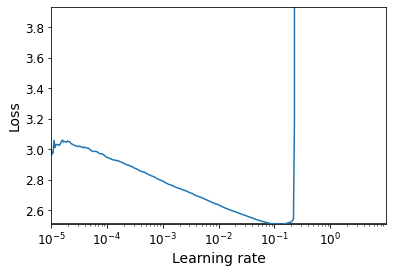

In [25]:
# define model
def get_model(drop_rate):
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    for _ in range(20):
        model.add(keras.layers.Dense(100,
                                     kernel_initializer="lecun_normal",
                                     activation="selu"))

    model.add(keras.layers.AlphaDropout(rate=drop_rate))
    model.add(keras.layers.Dense(10, activation="softmax"))

    optimizer = keras.optimizers.SGD(lr=1e-3, momentum=0.9)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

model = get_model(drop_rate=0.25)
batch_size = 128
# get rates and losses
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
# rate/loss plot 
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [27]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.max_momentum = 0.95
        self.min_momentum = 0.85
        self.last_momentum = 0.95
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            momentum = self._interpolate(0, self.half_iteration, self.max_momentum, self.min_momentum)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
            momentum = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.min_momentum, self.max_momentum)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
            momentum = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.max_momentum, self.min_momentum)
            momentum = max(momentum, self.max_momentum)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        K.set_value(self.model.optimizer.momentum, momentum)

model = get_model(drop_rate=0.2)
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 2s 5ms/step - loss: 1.9550 - accuracy: 0.3024 - val_loss: 1.9487 - val_accuracy: 0.3622
Epoch 2/15
352/352 [==============================] - 2s 5ms/step - loss: 1.7458 - accuracy: 0.3811 - val_loss: 1.8067 - val_accuracy: 0.4142
Epoch 3/15
352/352 [==============================] - 2s 5ms/step - loss: 1.6632 - accuracy: 0.4159 - val_loss: 1.7410 - val_accuracy: 0.4268
Epoch 4/15
352/352 [==============================] - 2s 5ms/step - loss: 1.6137 - accuracy: 0.4320 - val_loss: 1.7015 - val_accuracy: 0.4236
Epoch 5/15
352/352 [==============================] - 2s 5ms/step - loss: 1.5691 - accuracy: 0.4523 - val_loss: 1.6533 - val_accuracy: 0.4486
Epoch 6/15
352/352 [==============================] - 2s 5ms/step - loss: 1.5334 - accuracy: 0.4647 - val_loss: 1.6567 - val_accuracy: 0.4648
Epoch 7/15
352/352 [==============================] - 2s 5ms/step - loss: 1.4983 - accuracy: 0.4759 - val_loss: 1.6867 - val_accuracy: 0.4530
Epoch 

In [28]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.6171 - accuracy: 0.5382


[1.6171127557754517, 0.5382000207901001]

In [38]:
# MCAlphaDropout 
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# replace AlphaDropout layers with MCAlphaDropout
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

# define function to get class probabilities for each sample in data
def mc_dropout_predict_probas(mc_model, X, n_samples):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

# define function to predict class based on maximum probability 
def mc_dropout_predict_classes(mc_model, X, n_samples):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [37]:
# compare different settings of n_samples hyperparameter for MCDropout inference
for n_samples in [10, 50, 100, 150, 200]:
    start = timeit.default_timer()
    y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled, n_samples)
    accuracy = np.mean(y_pred == y_valid[:, 0])
    print("MCDropout {}-sample accuracy is {}. Time taken: {} seconds.".format(n_samples, accuracy, round(timeit.default_timer() - start)))

MCDropout 10-sample accuracy is 0.5396. Time taken: 3 seconds.
MCDropout 50-sample accuracy is 0.5392. Time taken: 16 seconds.
MCDropout 100-sample accuracy is 0.5406. Time taken: 33 seconds.
MCDropout 150-sample accuracy is 0.5396. Time taken: 48 seconds.
MCDropout 200-sample accuracy is 0.5394. Time taken: 65 seconds.
